In [7]:
import numpy as np
import matplotlib.pylab as plt
import os, sys
from scipy import stats
from scipy.ndimage import gaussian_filter1d
sys.path.append(os.path.join('.', 'physion', 'src'))
from physion.analysis.read_NWB import Data
from physion.dataviz.raw import plot, find_default_plot_settings
from physion.dataviz.pupil import *
import plot_tools as pt

In [8]:
def norm(x):
    return (x-x.min())/(x.max()-x.min())
    
def is_running(data,
               threshold=0.2,
               merging_window=0.5):
    
    running_speed = data.build_running_speed(\
                    specific_time_sampling=data.t_dFoF)

    # larger than threshold
    run = running_speed>threshold
    # merging nearby episodes
    for i in np.arange(len(data.t_dFoF))[run]:
        iNext = np.flatnonzero(run[i+1:])
        if len(iNext)>0 and\
            ((data.t_dFoF[i+iNext[0]]-\
                  data.t_dFoF[i])<merging_window):
            run[i+1:i+1+iNext[0]] = True

    return run

def is_whisking(data,
                threshold=0.2,
                merging_window=0.5):
    
    facemotion = data.build_facemotion(specific_time_sampling=data.t_dFoF)
    #facemotion = gaussian_filter1d(facemotion, 5)
        
    norm_fm = norm(facemotion)
    
    # larger than threshold
    whisking = norm_fm>threshold
    # merging nearby episodes
    for i in np.arange(len(data.t_dFoF))[whisking]:
        iNext = np.flatnonzero(whisking[i+1:])
        if len(iNext)>0 and\
            ((data.t_dFoF[i+iNext[0]]-\
                  data.t_dFoF[i])<merging_window):
            whisking[i+1:i+1+iNext[0]] = True

    return whisking

def is_whiskingOnly(data, run, whisk,
                    discard_pre=0.5,
                    discard_post=1.5):
    # not running
    whiskOnly = whisk & ~run
    
    # discard surrounding intervals
    for i in np.arange(len(data.t_dFoF))[whiskOnly]:
        # not in the post window
        iNext = np.flatnonzero(run[i+1:])
        if len(iNext)>0 and\
            ((data.t_dFoF[i+iNext[0]]-\
                  data.t_dFoF[i])<discard_pre):
            whiskOnly[i:i+1+iNext[0]] = False
        # not in the pre window
        iPrev = np.flatnonzero(run[:i+1][::-1])
        if len(iPrev)>0 and\
            ((data.t_dFoF[i]-\
                  data.t_dFoF[i-iPrev[0]])<discard_post):
            whiskOnly[i-iPrev[0]:i] = False
    return whiskOnly

def is_runningOnly(data, run, whisk,
                   discard_pre=0.5,
                   discard_post=1.5):
    # not running
    runOnly = run & ~whisk
    
    # discard surrounding intervals
    for i in np.arange(len(data.t_dFoF))[runOnly]:
        # not in the post window
        iNext = np.flatnonzero(whisk[i+1:])
        if len(iNext)>0 and\
            ((data.t_dFoF[i+iNext[0]]-\
                  data.t_dFoF[i])<discard_pre):
            runOnly[i:i+1+iNext[0]] = False
        # not in the pre window
        iPrev = np.flatnonzero(whisk[:i+1][::-1])
        if len(iPrev)>0 and\
            ((data.t_dFoF[i]-\
                  data.t_dFoF[i-iPrev[0]])<discard_post):
            runOnly[i-iPrev[0]:i] = False
    return runOnly

def is_stationary(data, run,
                  discard_pre=0.5,
                  discard_post=1.5):
    # not running
    stat = ~run
    # discard surrounding intervals
    for i in np.arange(len(data.t_dFoF))[stat]:
        # not in the post window
        iNext = np.flatnonzero(run[i+1:])
        if len(iNext)>0 and\
            ((data.t_dFoF[i+iNext[0]]-\
                  data.t_dFoF[i])<discard_pre):
            stat[i:i+1+iNext[0]] = False
        # not in the pre window
        iPrev = np.flatnonzero(run[:i+1][::-1])
        if len(iPrev)>0 and\
            ((data.t_dFoF[i]-\
                  data.t_dFoF[i-iPrev[0]])<discard_post):
            stat[i-iPrev[0]:i] = False

    return stat

In [5]:
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'DEMO-PYR', '2023_12_20-15-27-46.nwb')
data = Data(filename)
data.build_dFoF()
run = is_running(data)
whisk = is_whisking(data)
whiskOnly = is_whiskingOnly(data, run, whisk)
runOnly = is_runningOnly(data, run, whisk)
stat = is_stationary(data, run | whisk)

NWB-file reading time: 102.0ms

calculating dF/F with method "percentile" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)


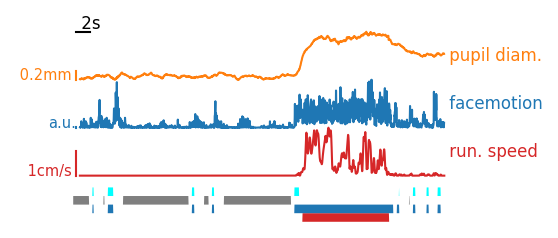

In [4]:
settings = {
 'Locomotion': {'fig_fraction': 1, 'subsampling': 1, 'color': 'tab:red'},
 'FaceMotion': {'fig_fraction': 1, 'subsampling': 1, 'color': 'tab:blue'},
 'Pupil': {'fig_fraction': 1, 'subsampling': 1, 'color': 'tab:orange'}}
fig, AX = pt.figure(axes_extents=[[[1,4]],[[1,1]]], hspace=0.1, figsize=(1.7,0.4))
tzoom = [113,168]
plot(data, tzoom, settings, ax=AX[0], Tbar=2)
cond = (data.t_dFoF>tzoom[0]) & (data.t_dFoF<tzoom[1])
AX[1].fill_between(data.t_dFoF[cond], 0*run[cond], 1.*run[cond], color='tab:red', lw=0)
AX[1].fill_between(data.t_dFoF[cond], 0*whisk[cond]+1, 1.*whisk[cond]+1, color='tab:blue', lw=0)
AX[1].fill_between(data.t_dFoF[cond], 0*stat[cond]+2, 1.*stat[cond]+2, color='tab:grey', lw=0)
AX[1].fill_between(data.t_dFoF[cond], 0*whisk[cond]+3, 1.*whiskOnly[cond]+3, color='cyan', lw=0)
AX[1].set_xlim(tzoom)
AX[1].axis('off')
fig.savefig('/Users/yann/Desktop/temp.svg')

Sampling frequency: 30.0 Hz  (datafile: /Users/yann/UNPROCESSED/DEMO-PYR/15-27-46/FaceCamera-imgs)
Sampling frequency: 24.0 Hz  (datafile: /Users/yann/UNPROCESSED/DEMO-PYR/15-27-46/RigCamera-imgs)


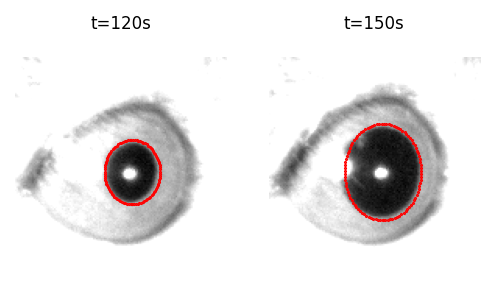

In [5]:
# find the 
raw_data_folder = os.path.join(os.path.expanduser('~'), 'UNPROCESSED', 'DEMO-PYR', '15-27-46')
metadata = np.load(os.path.join(raw_data_folder, 'metadata.npy'),
                   allow_pickle=True).item()

loadCameraData(metadata, raw_data_folder)

fig, AX = plt.subplots(1, 2, figsize=(4,2))

for ax, t in zip(AX, [120,150]):
    show_pupil(metadata, t=t, ax=ax)
    ax.axis('off')
    ax.axis('equal')
    ax.set_title('t=%is'%t)
fig.savefig('/Users/yann/Desktop/temp.svg')

In [ ]:
from physion.analysis.read_NWB import scan_folder_for_NWBfiles
DATASET = scan_folder_for_NWBfiles('/Users/yann/CURATED/SST-WT-NR1-GluN3-2023/', verbose=False)

In [16]:
STAT, RUN, WO = [], [], []
RUN_FRAC, WHISK_FRAC = [], []
RUNONLY_FRAC, WHISKONLY_FRAC = [], []
for filename in DATASET['files']:
    try:
        data = Data(filename, verbose=False)
        data.build_dFoF(verbose=False)
        run = is_running(data)
        whisk = is_whisking(data)
        whiskOnly = is_whiskingOnly(data, run, whisk)
        runningOnly = is_runningOnly(data, run, whisk)
        stat = is_stationary(data, run | whisk)
        pupil = data.build_pupil_diameter(specific_time_sampling=data.t_dFoF)
        norm_pupil = norm(pupil)
        STAT.append(np.mean(norm_pupil[stat]))
        RUN.append(np.mean(norm_pupil[run]))
        WO.append(np.mean(norm_pupil[whiskOnly]))
        RUN_FRAC.append(np.sum(run)/len(run))
        WHISK_FRAC.append(np.sum(whisk)/len(whisk))
        RUNONLY_FRAC.append(np.sum(runOnly)/len(runOnly))
        WHISKONLY_FRAC.append(np.sum(whiskOnly)/len(whiskOnly))
    except BaseException as be:
        pass

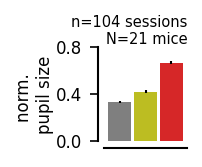

In [9]:
fig, ax = pt.figure(figsize=(.8,1))
pt.bar([np.nanmean(STAT), np.nanmean(WO), np.nanmean(RUN)], 
       sy=[stats.sem(STAT, nan_policy='omit'), stats.sem(WO, nan_policy='omit'), stats.sem(RUN, nan_policy='omit')], 
       COLORS=['tab:grey', 'tab:olive', 'tab:red'],
       ax=ax)
pt.set_plot(ax, xticks=[], ylabel='norm. \npupil size', yticks=[0,.4,.8])
pt.annotate(ax, 'n=%i sessions\nN=%i mice' % (np.sum(np.isfinite(STAT)), len(np.unique(DATASET['subjects']))), 
            (1,1), ha='right', fontsize=7)
fig.savefig('/Users/yann/Desktop/temp.svg')

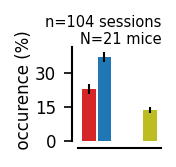

In [24]:
fig, ax = pt.figure(figsize=(.8,1))
pt.bar([100.*np.nanmean(RUN_FRAC), 100.*np.nanmean(WHISK_FRAC), 
        0, 
        100.*np.nanmean(RUNONLY_FRAC), 100.*np.nanmean(WHISKONLY_FRAC)], 
       sy=[100.*stats.sem(RUN_FRAC, nan_policy='omit'), 100.*stats.sem(WHISK_FRAC, nan_policy='omit'), 
           0,
           100.*stats.sem(RUNONLY_FRAC, nan_policy='omit'), 100.*stats.sem(WHISKONLY_FRAC, nan_policy='omit')], 
       COLORS=['tab:red', 'tab:blue', 'w', 'darkred', 'tab:olive'],
       ax=ax)
pt.set_plot(ax, xticks=[], ylabel='  occurence (%)' )#, yticks=[0,.4,.8])
pt.annotate(ax, 'n=%i sessions\nN=%i mice' % (np.sum(np.isfinite(STAT)), len(np.unique(DATASET['subjects']))), 
            (1,1), ha='right', fontsize=7)
fig.savefig('/Users/yann/Desktop/temp.svg')

In [22]:
print('Running only: %.3f %%' % (100.*np.nanmean(RUNONLY_FRAC)))

Running only: 0.011 %
